#Time-Series Visualize Intermediate Representations
ts_visualize_ir.ipynb

This notebook allows for data exploration using the intermediate representation formats (IR1 dataframes, IR2 and final numpy arrays) defined in the LLVM inspired architecure of the load_data_time_series work.

Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2023

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

TODO:
* Not all datasets are supported and tested, need to work through them.
* The graphs could always use updates to be more clear and informative.



In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
#imports for computing and displaying output metrics
from tabulate import tabulate # for verbose tables, showing data
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import urllib.request # to get files from web w/o !wget
from datetime import timedelta

In [2]:
verbose = True # these are here for compatibility so functions can be moved
interactive = True

# Get Transform (xform) functions to help with plotting

In [3]:
def get_py_file(fname, url):
    """checks for local file, if none downloads from URL.    
    :return: nothing"""
    if (os.path.exists(fname)):
        print ("Local",fname, "found, skipping download")
    else:
        print("Downloading",fname, "from IMICS git repo")
        urllib.request.urlretrieve(url, filename=fname)

In [4]:
try:
    import load_data_transforms as xform
except:
    get_py_file(fname = 'load_data_transforms.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_transforms.py')
    import load_data_transforms as xform

try:
    import load_data_utils as utils  
except:
    get_py_file(fname = 'load_data_utils.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_utils.py')
    import load_data_utils as utils

In [5]:
#@title Select Dataset
dataset = "TWristAR" #@param ["TWristAR","TWristAR Free-Form","Gesture Phase Segmentation","PSG-Audio", "CMU Motion Capture Brownie"]

# Get the dataset loaders to grab a dictionary of IR1 formatted data

In [6]:
print("Getting", dataset, "Dataset")
if dataset == "TWristAR":
    try:
        import twristar_load_dataset as twristar
    except:
        get_py_file(fname = 'twristar_load_dataset.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/TWristAR/twristar_load_dataset.py')
        import twristar_load_dataset as twristar
    twristar.scripted = True # set back to default if unscripted previously run
    ir1_dict = twristar.get_twristar_ir1_dict()
    label_dict = twristar.label_map_twristar
elif dataset == "TWristAR Free-Form":
    try:
        import twristar_load_dataset as twristar
    except:
        get_py_file(fname = 'twristar_load_dataset.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/TWristAR/twristar_load_dataset.py')
        import twristar_load_dataset as twristar
    twristar.scripted = False # this is a param in the loader, not a passed arg
    ir1_dict = twristar.get_twristar_ir1_dict()
    label_dict = twristar.label_map_twristar
elif dataset == "Gesture Phase Segmentation":
    try:
        import gesture_phase_segmentation_load_dataset as gps
    except:
        get_py_file(fname = 'gesture_phase_segmentation_load_dataset.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/Gesturing_Signing/gesture_phase_segmentation_load_dataset.py')
        import gesture_phase_segmentation_load_dataset as gps
    ir1_dict = gps.get_gps_ir1_dict()
    label_dict = gps.label_map_gps
elif dataset == "PSG-Audio":
    # PSG-Audio is so big, that the IR1s are in 5 2GB zip files, just get first one
    #https://drive.google.com/file/d/1j3cUvsQArIIUu0OZIvIVcP_FtqKhTavv/view?usp=sharing
    !gdown "1j3cUvsQArIIUu0OZIvIVcP_FtqKhTavv&confirm=t" # PSG-Audio zipped IR1 1 of 5
    utils.unzip_into_dir('PSG_18ch_IR1_1_of_5.zip','PSG_IR1')
    psg_df = pd.read_pickle("./PSG_IR1/995_ir1_df.pkl.zip")

    print("Grabbing a slice of PSG-Audio data, plotting a full night session takes ~10min in colab")
    print("Original Start Time", psg_df.index[0])
    print("Original End Time  ", psg_df.index[-1])
    psg_df = psg_df.loc['2019-04-17 22:44:35':'2019-04-17 22:44:55']
    # putting a resample here would probably help with drawing time
    ir1_dict = {'995_ir1_df': psg_df} # just for compatibility
    # TODO label_dict is in the PSG downloader, should get from there.
    label_dict = dict(
    Cardiac = {'Normal':0,'Bradycardia':1,'Tachycardia':2,'LongRR':3,'PttDrop':4,'HeartrateDrop':5,'HeartRateRise':6,'Asystole':7,'SinusTachycardia':8,'NarrowComplexTachycardia':9,'WideComplexTachycardia':10,'AtrialFibrilation':11},
    Limb = {'Normal':0,'LegMovement':1,'AlternatingLegMuscleActivation':2,'HypnagogicFootTremor':3,'ExcessiveFreagmentaryMyoclonus':4,'RythmicMovementDisorder':5},
    Nasal = {'Normal':0, 'Snore':1 },
    Neuro = {'Normal':0,'Arousal':1},
    Respiratory = {'Normal':0,'ObstructiveApnea':1,'CentralApnea':2,'MixedApnea':3,'Hypopnea':4,'CheyneStokesRespiration':5,'PeriodicRespiration':6,'Respiratoryeffort-relatedarousal(RERA)':7},
    SpO2 = {'Normal':0,'RelativeDesaturation':1,'AbsoluteDesaturation':2})
elif dataset == "CMU Motion Capture Brownie":
    try:
        import cmu_mocap_load_dataset as cmu
    except:
        get_py_file(fname = 'cmu_mocap_load_dataset.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/ADL/CMU-kitchen/cmu_mocap_load_dataset.py')
        import cmu_mocap_load_dataset as cmu
    ir1_dict = cmu.get_cmu_mocap_ir1_dict(incl_frame_num = True)
    label_dict = cmu.label_map_cmu
else:
    print("Error",dataset,"not found")
key_list = list(ir1_dict) # ir1_dict.keys() returns a dict_keys type
my_key = 0 # sort of a global

Getting TWristAR Dataset
Unzipping TWristAR file in . directory


# Running the next cell will cycle through all of the IR1 dataframes in the dictionary

        Dataset:  TWristAR Source file: 1574624998_A01F11 Start Time 2019-11-24 19:49:58 End Time  2019-11-24 19:57:15 Duration 00:07:17


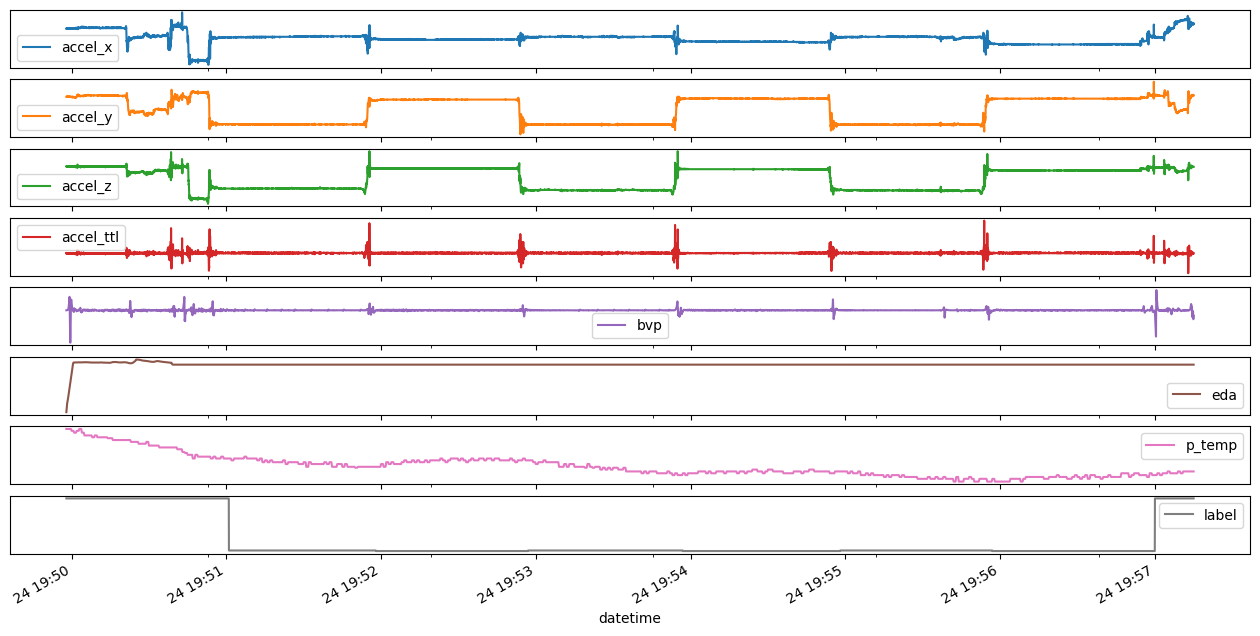

In [9]:
print("        Dataset: ", dataset, "Source file:",key_list[my_key], end='')
my_df = ir1_dict[key_list[my_key]]
# Funny string splits are just to get rid of too much nanosecond clutter
print(" Start Time", str(my_df.index[0]).split('.')[0], end='')
print(" End Time ", str(my_df.index[-1]).split('.')[0], end='')
dur = str(my_df.index[-1]-my_df.index[0])
hhmmss_dur = dur.split('.')[0].split(' ')[-1]
print(" Duration", hhmmss_dur)

# special processing for CMU - not sure why plotting is so slow
if dataset == "CMU Motion Capture Brownie":
    my_df.index = my_df['frame_number'] # too slow to use datetime index

# convert dataframe categorical strings to ints per label mapping dict (so they can be plotted and take less room)
my_df = xform.assign_ints_ir1_labels(my_df, label_mapping_dict = label_dict)
my_df.plot(subplots=True, figsize=(16, 8), yticks=[])
my_key = (my_key + 1) % len(key_list)

# should be able to control output further as pandas generates matplotlib obj
# https://pandas.pydata.org/docs/getting_started/intro_tutorials/04_plotting.html

# Get the TWristAR numpy arrays (IR2) to view sliding windows
Be careful of inspecting the test arrays!   The last version of this notebook in the internal repo has lot more per subject code from when IR3 contained both train and test data.  This was changed because it could result in leakage for more complex datasets that need further processing such as rebalancing training class.

In [10]:
try:
    import twristar_load_dataset as twristar
except:
    get_py_file(fname = 'twristar_load_dataset.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/TWristAR/twristar_load_dataset.py')
    import twristar_load_dataset as twristar
twristar.scripted = True # set back to default if unscripted previously run
ir1_dict = twristar.get_twristar_ir1_dict()
label_dict = twristar.label_map_twristar

In [12]:
print("All channels    ",twristar.all_channel_list)
keep_channels = ['accel_x', 'accel_y', 'accel_z', 'accel_ttl']
print("Keeping channels",keep_channels)
twristar.subj_dict = dict(train_subj = [1,2],
                validation_subj = [],
                test_subj = [3])

x_train, y_train, x_test, y_test= twristar.twristar_load_dataset( 
                                one_hot_encode = False,
                                keep_channel_list = ['accel_x', 'accel_y', 'accel_z', 'accel_ttl'],
                                incl_val_group = False)

print(utils.tabulate_numpy_arrays({"x_train":x_train,"y_train":y_train,
                                   "x_test":x_test,"y_test":y_test}))
# Convert the integer encoding back to strings
xform.verbose = True
y_train = xform.get_ir2_y_string_labels(y_train, label_map = twristar.label_map_twristar)
xform.verbose = False

All channels     ['accel_x', 'accel_y', 'accel_z', 'accel_ttl', 'bvp', 'eda', 'p_temp']
Keeping channels ['accel_x', 'accel_y', 'accel_z', 'accel_ttl']
array    shape          data type
-------  -------------  -----------
x_train  (2077, 96, 4)  float32
y_train  (2077, 1)      int8
x_test   (1091, 96, 4)  float32
y_test   (1091, 1)      int8
{'Downstairs': 0, 'Jogging': 1, 'Sitting': 2, 'Standing': 3, 'Upstairs': 4, 'Walking': 5, 'Undefined': 99}
{0: 'Downstairs', 1: 'Jogging', 2: 'Sitting', 3: 'Standing', 4: 'Upstairs', 5: 'Walking', 99: 'Undefined'}
Labels and counts before conversion
[[  0 317]
 [  1 347]
 [  2 353]
 [  3 342]
 [  4 370]
 [  5 348]]
Labels and counts after conversion
[['Downstairs' '317']
 ['Jogging' '347']
 ['Sitting' '353']
 ['Standing' '342']
 ['Upstairs' '370']
 ['Walking' '348']]


# Plots based on the numpy arrays

In [13]:
#Find min and max values for consistent plot scales
min_g = np.nanmin(x_train[::1])
max_g = np.nanmax(x_train[::1])
print ('min g value is',min_g,'max g value is',max_g)

min g value is -2.0 max g value is 2.0159488


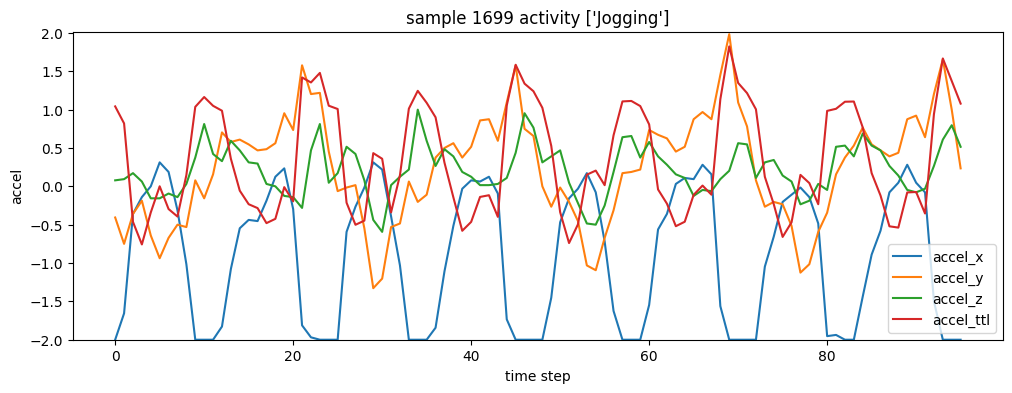

In [15]:
#@title Select Activity (each cell execution will display a random sample)
act_label = "Jogging" #@param ['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking']

# Plot a random sample - each time cell is run a new one appears
# find index of rows were both sub and activity match
# see https://stackoverflow.com/questions/57496890/numpy-where-matching-two-specific-columns
all_index = np.where(np.all(y_train == act_label, axis=1))
sample_num = np.random.choice(all_index[0], size=1)[0]
plt.figure(figsize=(12,4))
plt.ylim([min_g, max_g])
plt.plot(x_train[sample_num])
plt.title('sample '+str(sample_num)+' activity '+str(y_train[sample_num]))
plt.xlabel("time step")
# Note legend is specific to a version of TWristAR - need to fully implement a
# dictionary with channel names to accomodate all datasets.
plt.ylabel("accel")
plt.legend(keep_channels)
plt.show()

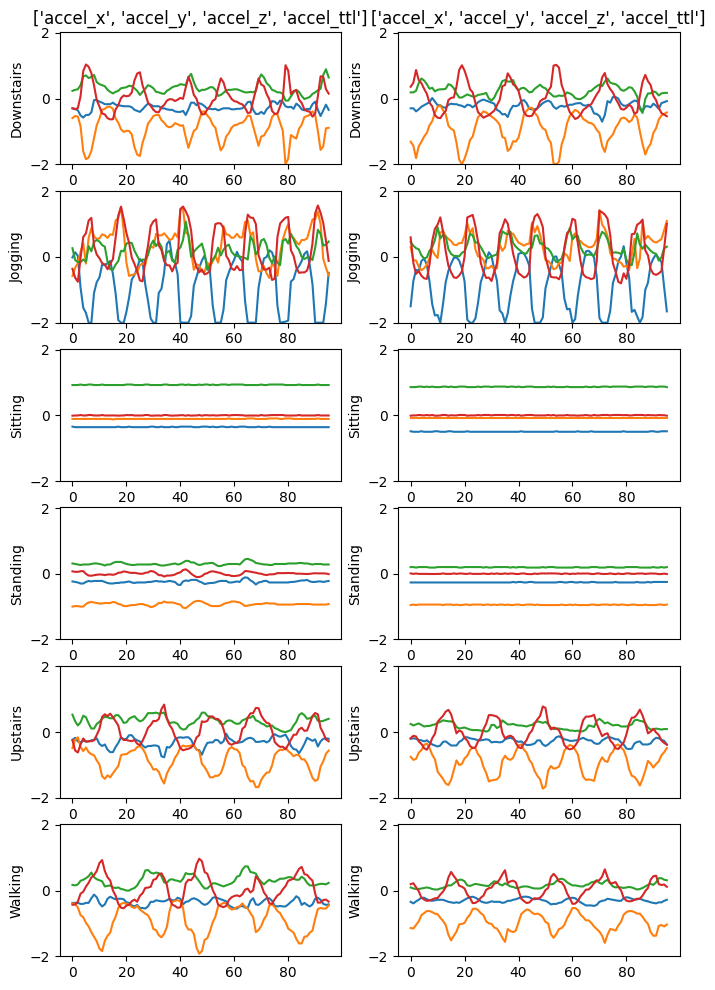

In [16]:
# Plot two random samples - this time side by side for all activities
l_sub = 1
r_sub = 2
l_idx_list = [] # empty lists to add sample numbers for left and right graphs
r_idx_list = []
unique_labels = np.unique(y_train) # note this works because TWristAR has string lbls
for act_label in unique_labels:
    all_index = np.where(np.all(y_train == act_label, axis=1))
    l_index = np.random.choice(all_index[0], size=1)[0]
    l_idx_list.append(l_index)
    all_index = np.where(np.all(y_train == act_label, axis=1))
    r_index = np.random.choice(all_index[0], size=1)[0]
    r_idx_list.append(r_index)

# plot side by side - leveraged from final plot in ts_throwdown which is pngs.
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html?highlight=subplots
# see https://matplotlib.org/stable/tutorials/intermediate/gridspec.html#sphx-glr-tutorials-intermediate-gridspec-py
# see https://matplotlib.org/stable/tutorials/intermediate/tight_layout_guide.html
if (len(l_idx_list) != len(r_idx_list)):
    print("Something went wrong - number of left & right indices aren't equal")
rows = len(l_idx_list)
cols = 2
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize = (8, 12), dpi = 100)
# might want to increase dpi if saving figure; it slows down display time
# I am not proud of the goofy list comprehension, trying to get graphs right!
for r in range(rows):
    for c in range(cols):
        if (r == 0):
            axs[r, c].set_title(keep_channels)
        #axs[r, c].set_axis_off()
        if (c == 0):
            axs[r, c].plot(x_train[l_idx_list[r]])
        else:
            axs[r, c].plot(x_train[r_idx_list[r]])
        axs[r,c].set_ylim(min_g, max_g)
        axs[r,c].set(ylabel=unique_labels[r])
        #axs[r,c].grid(True)